- In this notebook we will continue our analysis on bike data by applying tree based models 
- We will implement Random Forest, Adaboost, Gradient Boosting and Stochastic Gradient Boosting algorithms
- We will submit our predictions to Kaggle at the end.
- Since trees and ensembles have many hyperparameters, in this notebook we try to explain some good practice regarding the usage of these hyperparameters
- Also we will implement Grid Search in order to tune these hyperparameters


![villo](/images/villo.jpg)

<!-- TEASER_END -->

## Notebook Setup

In [2]:
# Import the necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()

Lets start by loading our dataset that is prepared in the earlier post.

In [3]:
bike_data=pd.read_csv("bike_data_inliers.csv", parse_dates=["datetime"], index_col="datetime")
bike_data.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,weekday,hour
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1


In [4]:
## Filter out the casual and registered columns 
## Filter out the high correlated columns "season" (correlated with "month") and "temp" (correlated with "atemp") 
## Also in the previous posts we noticed that the data record in the "weather" column is not relaible
## We will also drop it
bike_data= bike_data.drop(["casual", "registered", "temp", "season", "weather"], axis=1)
bike_data.head(2)

,holiday,workingday,atemp,humidity,windspeed,count,month,weekday,hour
datetime,,,,,,,,,
2011-01-01 00:00:00,0,0,14.395,81,0.0,16,1,5,0
2011-01-01 01:00:00,0,0,13.635,80,0.0,40,1,5,1


## Split the data

- Even though there is a given test set (without target variable) for Kaggle submission we will analyse the data as an independent project and follow our data splitting principles for model evaluation

- At the end we will use the Kaggle test set for submission

- So after fitting a model we will use **cross validation** for evaluating the model performance and hyperparameter tuning but we still need to keep an **hold-out set** for our final evaluation. 

- Since this is a timeseries dataset we must respect to the temporal order of the data. Thus, we must use only the past data to predict the future data. 


- So we can take the **last %5** as our hold-out data. (In the Kaggle competition the test set is the last 10 days of the months)

In [5]:
# Find the starting indice of the last five percent
last_five_percent_ind= int(len(bike_data)* 0.95)
last_five_percent_ind

# Create the hold-out dataset
hold_out_df=bike_data.reset_index().iloc[last_five_percent_ind: ,:]

print("The shape of the hold-out dataset:", hold_out_df.shape)
hold_out_df.head(2)

The shape of the hold-out dataset: (522, 10)


,datetime,holiday,workingday,atemp,humidity,windspeed,count,month,weekday,hour
9914,2012-11-16 06:00:00,0,1,15.91,61,6.0032,130,11,4,6
9915,2012-11-16 07:00:00,0,1,15.15,61,11.0014,367,11,4,7


We will do training and cross validation on the rest of the data. Lets create it

In [6]:
data= bike_data.reset_index().iloc[:last_five_percent_ind, :]
data.tail(2)

,datetime,holiday,workingday,atemp,humidity,windspeed,count,month,weekday,hour
9912,2012-11-16 04:00:00,0,1,15.91,65,7.0015,5,11,4,4
9913,2012-11-16 05:00:00,0,1,15.91,65,6.0032,36,11,4,5


## Features and Target Variable

Having split the hold-out dataset, now time to create the features (X) and the target (y) datasets

In [45]:
# Target data
y=data["count"]

# Features data
X=data.drop(["datetime", "count"], axis=1)
X.head(2)

,holiday,workingday,atemp,humidity,windspeed,month,weekday,hour
0,0,0,14.395,81,0.0,1,5,0
1,0,0,13.635,80,0.0,1,5,1


### Hold-Out Features and Target Variable

In [7]:
# Create the features and target datasets from hold_out data
# Hold-out target
y_hold=hold_out_df["count"]

# Hold-out features data
X_hold=hold_out_df.drop(["datetime", "count"], axis=1)
X_hold.head(2)

,holiday,workingday,atemp,humidity,windspeed,month,weekday,hour
9914,0,1,15.91,61,6.0032,11,4,6
9915,0,1,15.15,61,11.0014,11,4,7


## RMSLE Calculator Function

In this Kaggle competion we seek to identify the models that result in predictions which minimize the Root Mean Squared Logaritmic Error (RMSLE). In the earlier post we talk about this metric in detail

In [47]:
# Define the RMSLE function for error calculation: rmsle_calculator
# Using the vectorized numpy functions instead of loops always better for computation
def rmsle_calculator(predicted, actual):
    assert len(predicted) == len(actual)
    return np.sqrt(
                np.mean(
                    np.power(np.log1p(predicted)-np.log1p(actual), 2)))

### Custom Scoring Function
- We should define a scoring function in order to use as a scoring parameter for `model_selection.cross_val_score`

- We need this parameter for model-evaluation tools which rely on a scoring strategy when using cross-validation internally (such as `model_selection.cross_val_score` and `model_selection.GridSearchCV`)

In [48]:
# Make a custom scorer 
# rmsle_error will negate the return value of rmsle_calculator,
rmsle_error = make_scorer(rmsle_calculator, greater_is_better=False)

##  Tips on Practical Use of Decision Trees
Before starting implemetation of Random Forest algorithm it would be nice to remind some practical tips about decision trees from Sklearn page. Here are some basic tips:

- Decision trees tend to overfit on data with a large number of features.
- Getting the right ratio of **samples** to **number of features** is important, since a tree with few samples in high dimensional space is very likely to overfit.
- Consider performing dimensionality reduction (**PCA, ICA**, or **Feature selection**) beforehand to give your tree a better chance of finding features that are discriminative.
- Remember that the number of samples required to populate the tree **doubles for each additional level** the tree grows to. 
- Use `max_depth` to control the size of the tree to prevent overfitting.
- Use `max_depth=3` as an initial tree depth to get a feel for how the tree is fitting to your data, and then increase the depth.

- Use `min_samples_split` or `min_samples_leaf` to ensure that multiple samples inform every decision in the tree, by controlling which splits will be considered. 
    - `min_samples_split` can create arbitrarily small leaves,
    - `min_samples_leaf` guarantees that each leaf has a minimum size, avoiding low-variance, over-fit leaf nodes
    - A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data. 
    - Try `min_samples_leaf=5` as an initial value. 
    - If the sample size varies greatly, a **float number** can be used as percentage in these two parameters. 
    - For classification **with few classes**, `min_samples_leaf=1` is often the best choice.


- Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant. 
    - Class balancing can be done by sampling an equal number of samples from each class, or 
    - preferably by normalizing the sum of the sample weights (`sample_weight`) for each class to the same value. 
    - Also note that weight-based pre-pruning criteria, such as `min_weight_fraction_leaf`, will then be less biased toward dominant classes than criteria that are not aware of the sample weights, like `min_samples_leaf`.
    
    
        
- If the samples are weighted, it will be easier to optimize the tree structure using weight-based pre-pruning criterion such as `min_weight_fraction_leaf`, which ensure that leaf nodes contain at least a fraction of the overall sum of the sample weights.
        
- If the input matrix X (features) is **very sparse**, it is recommended to convert to sparse `csc_matrix` before calling fit and sparse `csr_matrix` before calling predict. 

- Training time can be orders of magnitude faster for a sparse matrix input compared to a dense matrix when features have zero values in most of the samples.

# Random Forest Estimator (Forest of Randomized Trees)

- In Sklearn, bagging algorithms takes a user-specified base estimator along with parameters specifying the strategy to draw random subsets. 

- In `RandomForestRegressor` the base estimators are decision trees

- In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. 

- In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. 
    - Instead, the split that is picked is the best split among a random subset of the features. 
    

- As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.


- Like in the other bagging algorithms in RandomForestRegressor
    - `max_samples` and `max_features` control the size of the subsets (in terms of samples and features), 
    - `bootstrap` and `bootstrap_features` control whether samples and features are drawn with or without replacement. 


### Parameters of Random Forest

- The main parameters to adjust of random forest is `n_estimators` and `max_features`. 

- The `n_estimator` is the number of trees in the forest.
    - The larger the better, but also the longer it will take to compute. 
    - In addition, note that results will stop getting significantly better beyond a critical number of trees. 



- `max_features` is the size of the **random subsets of features** to consider when splitting a node. 
    - The lower the greater the reduction of variance, but also the greater the increase in bias.


- Empirical good default values are
    - `max_features=n_features` for regression problems, and 
    - `max_features=sqrt(n_features)` for classification tasks (where n_features is the number of features in the data). 


- Good results are often achieved when setting `max_depth=None` in combination with `min_samples_split=2` (i.e., when fully developing the trees). 

- Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of RAM. 
- The best parameter values should always be **cross-validated**. 

- In addition, note that in random forests, bootstrap samples are used by default (`bootstrap=True`) 

### Note

- The size of the model with the default parameters is $O(M*N*log(N)$ , where $M$ is the number of trees and $N$ is the number of samples. 
- In order to reduce the size of the model, you can change these parameters: 
    - `min_samples_split`, 
    - `max_leaf_nodes`,
    - `max_depth` and 
    - `min_samples_leaf`.

## Random Forest Model
After reminding the practical tips we can instantiate our Random Forest model

In [ ]:
# Instantiate a Random Forest object with parameters
random_forest=RandomForestRegressor(n_estimators=300,
                                         max_depth=6,
                                         max_features=6, 
                                         min_samples_leaf=8,
                                         random_state=1)

## Cross Validation Scores

Let's define a function for utilize the `cross_val_score` function from `sklearn.metrics` to get the scores of each split. We will calculate the scores with the metrics:
- **R_squared** 
- **RMSE**
- **MAE**, and
- **RMSLE** (Root Mean Squared Logarithmic Error, Kaggle's metric for this dataset. We will mainly take into account this metric)

In [50]:
# Define a function for calculating the cross validation scores with different metrics
def scores(X, y, split, metric_lst, estimator=random_forest):
    '''Takes features and target sets, a list of metrics and an estimator -> 
    returns the scores of the metrics in the list '''
    # Fit and score the model with cross-validation
    for metric_desc, metric_name in metric_lst:
        score= cross_val_score(estimator, X, y, cv=split, scoring=metric_name)
        if metric_name=="neg_mean_squared_error":
            print(f"RMSE values:{np.sqrt(-score)}")
            print()
        elif metric_name=="r2":
            print(f"{metric_desc} values:{score}")
            print()
        else:
            print(f"{metric_desc} values:{-score}")
            print()

In [51]:
# Create a metric list
metrics_lst=[("MAE", "neg_mean_absolute_error"), 
             ("MSE", "neg_mean_squared_error"), 
             ("R^2", "r2"),
             ("MSLE", rmsle_error), # Our custom defined RMSLE 
             ("MSLE", "neg_mean_squared_log_error")]

# Split the timeseries data with TimeSeriesSplit
time_split = TimeSeriesSplit(n_splits=5)

scores(X, y, time_split, metrics_lst, estimator=random_forest)

MAE values:[72.19103188 46.93845747 67.0675416  74.70634337 68.92369856]

RMSE values:[104.52779911  71.88854555 105.68288502 105.67601192  97.75787222]

R^2 values:[0.48259751 0.73514714 0.29747846 0.60058387 0.64609849]

MSLE values:[0.61212597 0.52121142 0.70357754 0.50449061 0.46967002]

MSLE values:[0.37469821 0.27166134 0.49502135 0.25451078 0.22058993]



In [52]:
# Validate with the hold-out data
# Fit the data to random_forest
random_forest.fit(X, y)

# Predict the hold-out test set
pred=random_forest.predict(X_hold)

# Score the predictions with rmsle_calculator
rmsle_calculator(y_hold , pred)

0.45870403895429723

## Visualizing Features Importances
- Tree-based methods enable measuring the importance (predictivity) of each feature in prediction
- It is calculated by regarding how much the tree nodes use a particular feature to split the data and reduce the variance
- Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples.

- In Sklearn we can retreive the feature importance by using the attribute `feature_importance_`

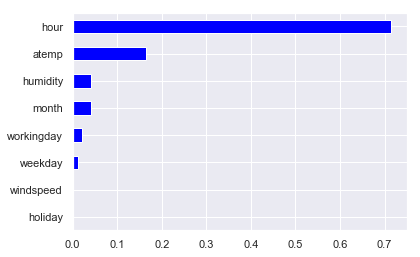

In [53]:
# Create a pandas Series of features importances: importances
# containing the feature names as index and their importances as values
importances = pd.Series(data=random_forest.feature_importances_ , index= X.columns)

# Get the sorted importance values: importance_sorted
importance_sorted=importances.sort_values()

# Plot the sorted importance values by using horizontal bars
importance_sorted.plot(kind="barh", color="blue");

Obviously,  `hour` and `atemp` (temperature) are the most predictive features according to our `random_forest` model. The importances of these two features add up to `more than 90%`

## Kaggle submission for Random Forest Model

Now time to predict the given Kaggle test set and submit the predictions to Kaggle to get our score.
- First, lets read the Kaggle test data and apply all the same steps that we did for the training set like creating new features in order to make them match

- Second, it would be better if we combine our `X` and `X_hold` and `y` and `y_hold` datasets then train our model with more data in order to let our model learn better before predicting on a new test data i.e Kaggle test dataset which we have not yet uploaded.

In [54]:
# Read the Kaggle test data
kaggle_test=pd.read_csv("bike_kaggle_test.csv", parse_dates=["datetime"], index_col="datetime")

# Create the time features "month","weekday" and "hour"
kaggle_test["month"]=kaggle_test.index.month
kaggle_test["weekday"]=kaggle_test.index.dayofweek
kaggle_test["hour"]=kaggle_test.index.hour
kaggle_test.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,weekday,hour
datetime,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,3,0
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,1
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,2


In [55]:
# Drop the index
X_kaggle_test= kaggle_test.reset_index(drop=True)
# Drop the unnecessary columns
X_kaggle_test=X_kaggle_test.drop(["temp", "season", "weather"], axis=1)
X_kaggle_test.head(3)

,holiday,workingday,atemp,humidity,windspeed,month,weekday,hour
0,0,1,11.365,56,26.0027,1,3,0
1,0,1,13.635,56,0.0000,1,3,1
2,0,1,13.635,56,0.0000,1,3,2


###  Fit Combined Data to Random Forest Model

In [56]:
# Combine X and X hold: combined_train
combined_X=pd.concat([X, X_hold])

# Combine the y and y hold: combined_test
combined_y =pd.concat([y, y_hold])

random_forest.fit(combined_X, combined_y)

# Predict the Kaggle test set
final_predictions_rf=random_forest.predict(X_kaggle_test)

Having predicted the test targets now we need to create a dataframe complying with Kaggle submission format 

In [57]:
kaggle_sub_rf=pd.DataFrame({"datetime":kaggle_test.index, "count":final_predictions_rf}).set_index("datetime")
kaggle_sub_rf.head(3)

,count
datetime,
2011-01-20 00:00:00,17.469270
2011-01-20 01:00:00,10.278210
2011-01-20 02:00:00,6.495004


In [58]:
# Save the submission dataframe
kaggle_sub_rf.to_csv("kaggle_sub_rf.csv")

## Kaggle Results

![kagglerf](/images/kagglerf.jpg)

## OOB ('Out of the Bag' or 'Out of the Boot') Validation
- The single trees in Random Forest algorithm take the input data by randomly selecting with replacement from the original data (bootstrap samples)
- This means each tree very highly containing dublicated samples and not containing some of the samples in the original training set
- On average, 
    - for each model, `60%` of the training instances are sampled
    - each single tree does not use `40%` of the training instance. 
    - They are called "Out of the bag". A better name is "Out of Boot" because they are the ones not choosen by the bootstrap method
    
    
- This unseen samples can be used as validation set
- Random forest algorithm can run internally the single tree predictions on these OOB data
- Sometimes, our dataset can be very small and if we dont want to split it for the Validation set, OOB option can be a good alternative
- This allows us to see whether the model is `over-fitting`, without needing a `separate validation set`. 
- In Sklearn RandomForestRegressor the parameter for OOB option is `oob_score = True`. 

## OOB Error  and Timeseries Data
- OOB is good for especially small dataset which are not timeseries
- However OOB validation will give us a misleading evaluation of performance on a time-series dataset because it will be evaluating performance on past data using future data due to the random selection during the bootstrap method application
- Therefore, we need to use a methodology which respect to time order like `TimeSeriesSplit`.
- In this project we will not use OOB

# Adaboost

After implementing RandomForestRegressor now let's implement `AdaBoostRegressor`. 

Here are some reminders:
- In Adaboost we fit a new estimator repeatedly by modifing the data each time. 
- The data modifications at each boosting iteration consist of applying weights $w_1,...w_n$ to each of the training samples. 
- Initially, those weights are all equally set to $w_i=1/N$, so that the first step simply trains a weak learner on the original data. 
- For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data.

- At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. 

- As iterations proceed, examples that are difficult to predict receive ever-increasing influence. 
- Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.

**Important Parameters of Sklearn `AdaBoostRegressor`**
- `base_estimator` : The base estimator from which the boosted ensemble is built. Default is `DecisionTreeRegressor(max_depth=3)`. We can use a developped tree

- The complexity of the base estimators is important (e.g., its depth `max_depth` or minimum required number of samples to consider a split `min_samples_split`).

- `n_estimators` : The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early. Default is 50 

- `learning_rate` : Controls the contribution of the weak learners in the final combination. Learning rate shrinks the contribution of each regressor by the provided value. There is a trade-off between learning_rate and n_estimators. If learning rate is small the number of estimators will be large. A number beetween 0 and 1. Default is 0.1

- `loss` : The loss function to use when updating the weights after each boosting iteration.
Options are `linear`, `square`, `exponential`. Default is `linear`

- `random_state` : Since Boosting involves randomness when choosing the input data, it is important to seed this parameter in order to reproduce the same results later

In [59]:
# Instantiate a DecisionTreeRegressor with arguments
dtree = DecisionTreeRegressor(max_depth=6,
                              max_features=6, 
                              min_samples_leaf=8,
                             random_state=1)

# Instantiate an AdaBoostClassifier with 300 trees, 
adaboost = AdaBoostRegressor(base_estimator=dtree, 
                             n_estimators=300,
                             learning_rate=0.02,
                             random_state=1)

Let's evaluate the performance of AdaboostRegressor with scores function we defined earlier

In [60]:
# Calculate the scores
scores(X, y, time_split, metrics_lst, estimator=adaboost)

MAE values:[66.53556939 43.77378891 65.3348207  72.22024961 65.9730083 ]

RMSE values:[ 94.81543874  64.38501852 102.36121393 102.0862418   94.38518   ]

R^2 values:[0.57428101 0.78755088 0.34094573 0.62725897 0.67009678]

MSLE values:[0.57223361 0.51306689 0.68107254 0.48182514 0.45777072]

MSLE values:[0.3274513  0.26323764 0.46385981 0.23215547 0.20955404]



In [61]:
# Validate with the hold-out data
ada=adaboost.fit(X, y)
pred=ada.predict(X_hold)
rmsle_calculator(y_hold , pred)

0.4269805955614845

## Kaggle Submission Adaboost

In [62]:
ada=adaboost.fit(combined_X, combined_y)
final_predictions_ada= ada.predict(X_kaggle_test)
kaggle_sub_ada=pd.DataFrame({"datetime":kaggle_test.index, "count":final_predictions_ada}).set_index("datetime")
kaggle_sub_ada.head(3)

,count
datetime,
2011-01-20 00:00:00,16.488889
2011-01-20 01:00:00,9.366667
2011-01-20 02:00:00,6.297357


In [63]:
# Save the submission dataframe
kaggle_sub_ada.to_csv("kaggle_sub_ada.csv")

![kaggleada](/images/kaggleada.jpg)

## Grid Search Adaboost
Lets implement a short grid search for tuning some hyperparameters of adaboost

In [64]:
# First get the parameters of adaboost
adaboost.get_params()

{'base_estimator__criterion': 'mse',
 'base_estimator__max_depth': 6,
 'base_estimator__max_features': 6,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 8,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': 1,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best'),
 'learning_rate': 0.02,
 'loss': 'linear',
 'n_estimators': 300,
 'random_state': 1}

In [65]:
# Create the parameters grid for adaboost:params_ada
params_ada = {'n_estimators':[40, 50, 60],
              'learning_rate':[0.01, 0.02]}
    
# Instantiate a 3-fold CV grid search object:grid_ada
grid_ada= GridSearchCV(estimator=adaboost,
                         param_grid=params_ada,    
                         cv=5,
                         scoring="neg_mean_squared_log_error",
                         #verbose=True,
                         n_jobs=-1)

In [66]:
# Fit the combined data to grid_ada 
grid_ada.fit(combined_X, combined_y);

In [67]:
# Get the best parameters of the grid search
grid_ada.best_params_

{'learning_rate': 0.01, 'n_estimators': 50}

This grid search on two parameters did not improved the score. We need to do a more complex grid search with more parameters together but adding each new parameter makes the grid search computationaly more expensive. If you have time and gpu power you can give it a try

# Gradient Boosting
Let's continue our analysis by applying a `GradientBoostingRegressor` model to our data

- In contrast to Adaboost, in Gradient Boosting the weights of training samples are not modified between squential predictors.
- Instead each predictor is trained using the residual errors `(y-ŷ)` of its predecessors as target values(labels)
- One disadvantage of boosting algorithms is scalability, due to the sequential nature of boosting it can hardly be parallelized.

**Important Parameters of Sklearn `GradientBoostingRegressor`**

Since in each stage a regression tree is fit on the Sklearn `GradientBoostingRegressor` the parameters of DecisionTreeRegressor are also the parameters of GradientBoostingRegressor. However in `AdaboostRegressor` we provide the base estimator with a seperate parameter. 

- `n_estimators`: number of boosting stages, or trees, to use.
- `learning_rate`: A number beetween 0 and 1. Learning rate shrinks the contribution of each regressor by the provided value. There is a trade-off between learning_rate and n_estimators. If learning rate is small the number of estimators will be large. Default is 0.1
- `subsample`: The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
- `in_samples_leaf`: The minimum number of samples required to be at a leaf node
- `max_depth` : Maximum depth of the individual regression trees.

In [68]:
# Instantiate a GradientBoostingRegressor object
gbr=GradientBoostingRegressor(n_estimators=80, 
                              learning_rate=0.05,
                              max_depth=10,
                              min_samples_leaf=20,
                              random_state=5)

# Calculate the scores of GradientBoostingRegressor
scores(X, y, time_split, metrics_lst, estimator=gbr)

MAE values:[63.78243526 29.52160019 58.18626779 74.91291222 72.97491302]

RMSE values:[ 90.93426958  45.57951373  88.49253049 102.05948781  97.819009  ]

R^2 values:[0.60842039 0.89353064 0.507435   0.62745431 0.64565569]

MSLE values:[0.55231098 0.41224693 0.63309638 0.47929402 0.44532874]

MSLE values:[0.30504742 0.16994753 0.40081102 0.22972276 0.19831768]



## Kaggle Submission Gradient Boosting

In [69]:
gbr.fit(combined_X, combined_y)
final_predictions_gbr= gbr.predict(X_kaggle_test)
kaggle_sub_gbr=pd.DataFrame({"datetime":kaggle_test.index, "count":final_predictions_gbr}).set_index("datetime")
kaggle_sub_gbr["count"]=kaggle_sub_gbr["count"].abs()
kaggle_sub_gbr.head(3)

,count
datetime,
2011-01-20 00:00:00,17.592650
2011-01-20 01:00:00,9.359919
2011-01-20 02:00:00,7.708385


In [70]:
# Save the submission dataframe
kaggle_sub_gbr.to_csv("kaggle_sub_gbr.csv")

![kagglegbr](/images/kagglegbr.jpg)

# Stochastic Gradient Boosting

Each tree in the ensemble is trained to find the best features and the best split points. This may cause the decesion trees use the **same features** and the **same split points**. To decrease this effect we can use `Stochastic Gradient Boosting (SGB)` by introducing further randomization to Gradient Boosting
- In SGB each decision tree is trained on a random subset of the training data
- The subsets are choosen without replacement
- **At each node** to choose the best-splits the features are also choosen without replacement 
    - This create further diversity in the ensemble and add more variance 
    
    
- SGB combines gradient boosting with bootstrap averaging (bagging)

- Here we are using a similar sampling method as in Random Forest algorithm
- The difference is that the trees continue to be trained as in the Gradient Boosting ie after training the first tree the subsequent trees are trained regarding the residual errors of the preciding trees

#### `learning_rate` and `subsampling` effect
Some tips from Sklearn page:
- The figure below illustrates the effect of `shrinkage` and `subsampling` on the goodness-of-fit of the model. 
- We can clearly see that shrinkage outperforms no-shrinkage. 
- Subsampling with shrinkage can further increase the accuracy of the model. 
- Subsampling without shrinkage, on the other hand, does poorly.

![shrinkage](/images/shrinkage.jpg)

 - The number of subsampled features can be controlled via the `max_features` parameter.
 

**Note**: Using a small `max_features` value can significantly decrease the runtime. 

### Interpretation
- Individual decision trees can be interpreted easily by simply visualizing the tree structure. 
- Gradient boosting models, however, comprise hundreds of regression trees thus they cannot be easily interpreted by visual inspection of the individual trees. 
- But we can take the average of the feature importance of each tree to get the important features of the ensembles.
- The feature importance scores of a fit gradient boosting model can be accessed via the `feature_importances_` property

In [73]:
# Instantiate a GradientBoostingRegressor object
sgb=GradientBoostingRegressor(n_estimators=500,
                              subsample=0.5,
                              max_depth=4, 
                              min_samples_split= 2,
                              learning_rate=0.01, 
                              max_features=0.75,
                              random_state=5)

# Calculate the scores of GradientBoostingRegressor
scores(X, y, time_split, metrics_lst, estimator=sgb)

MAE values:[61.99985965 40.33608158 60.5692487  74.9969457  68.99776331]

RMSE values:[ 88.02700477  57.99335732  91.11700132 104.47887358  95.44953937]

R^2 values:[0.63305857 0.8276379  0.47778522 0.60958209 0.66261434]

MSLE values:[0.64242847 0.55233378 0.7128809  0.57816768 0.52222838]



## Kaggle Submission Stochastic Gradient Boosting

In [ ]:
sgb.fit(combined_X, combined_y)
final_predictions_sgb= sgb.predict(X_kaggle_test)
kaggle_sub_sgb=pd.DataFrame({"datetime":kaggle_test.index, "count":final_predictions_sgb}).set_index("datetime")
kaggle_sub_sgb["count"]=kaggle_sub_sgb["count"].abs()
kaggle_sub_sgb.head(3)

In [ ]:
# Save the submission dataframe
kaggle_sub_sgb.to_csv("kaggle_sub_sgb.csv")

![kagglesgb](/images/kagglesgb.jpg)

## Final Submission
Here are the models and the scores on Kaggle submission
- Random Forest :0.5271
- Adaboost:0.6493
- GradientBoostingRegressor: 0.5386
- Stochastic GradientBoosting: 0.6690

So we will submit the Random Forest.

- We should notice that ensemble algorithms have a lot of parameters to tune, i.e a lot of knobs that control the model. 

- The best way to optimize these knobs to make comprehensive Grid Searh or Randomized Search. In our notebook we did not do rigorous optimization though all the models performed better than the linear model in the earlier post.

This is a closed competion though to get a feeling of ranking here is our ranking falls in among 3,251 teams :)
![rank](/images/rank.jpg)

Sources: <br>
https://scikit-learn.org/stable/modules/ensemble.html 